Code for generating the results for synthetic linear Gaussian causal graphs (Fig. 10).

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import numpy
import pandas
import networkx
from itertools import combinations, permutations
import logging
from causallearn.utils.cit import CIT
from sklearn import linear_model
import collections
import matplotlib.pyplot as plt
import pickle as pkl
from datetime import datetime
import copy

from causal_discovery.utils import *
from causal_discovery.pc_alg import PCAlgorithm
from causal_discovery.mb_by_mb import MBbyMBAlgorithm
from causal_discovery.sd_alg import SequentialDiscoveryAlgorithm
from causal_discovery.ldecc import LDECCAlgorithm

In [ ]:
def get_params(num_conf, num_med, p_link_conf, p_link_conf_med, 
               p_link_med, p_link_x, p_link_y):

  def generate_links(max_links, prob_link, atleast_one=True):
    while True:
      links = np.random.binomial(n=1, p=prob_link, size=(max_links,))
      if not atleast_one or np.sum(links) > 0:
        return links
  
  # covariates + treatment + outcome
  A = np.zeros(shape=(num_conf + num_med + 2, num_conf + num_med + 2))

  # generate edges between the covariates
  for i in range(1, num_conf):
    A[i, :i] = generate_links(i, p_link_conf)
  
  # connect some covariates to the treatment.
  A[num_conf, :num_conf] = generate_links(num_conf, p_link_x)

  # connect the covariates to some mediators.
  for i in range(num_conf + 1, num_conf + 1 + num_med):
    A[i, :num_conf] = generate_links(num_conf, p_link_conf_med, atleast_one=False)

  # connect the treatment to some mediators
  A[num_conf+1, num_conf] = 1  # connect treatment to first mediator.
  if num_med > 1:
    A[num_conf+2:num_conf+1+num_med, num_conf] = generate_links(num_med-1, p_link_conf_med)
  
  # generate edges between the mediators
  for i in range(num_conf + 2, num_conf + 1 + num_med):
    A[i, num_conf + 1:i] = generate_links(i - (num_conf + 1), p_link_med)

  # add edges between covariates and outcome.
  A[num_conf+num_med+1, :num_conf] = generate_links(num_conf, p_link_y)

  # add edges between mediators and outcome.
  A[num_conf+num_med+1, num_conf+num_med] = 1 
  if num_med > 1: 
    A[num_conf+num_med+1, num_conf+1:num_conf+num_med] = generate_links(num_med - 1, p_link_y)

  # disconnect treatment from outcome.
  # A[-1, num_conf] = 0

  # A *= np.random.uniform(low=.1, high=1, size=A.shape)
  A *= np.random.uniform(low=.25, high=1, size=A.shape) * (2 * np.random.binomial(1, 0.5) - 1)

  labels = ["W%d" % d for d in range(1, num_conf + 1)]
  labels.append("X")
  labels += ["M%d" % d for d in range(1, num_med + 1)]
  labels.append("Y")

  # noise_vars = np.random.uniform(low=0.3, high=1, size=(num_conf+num_med+2))
  noise_vars = np.random.uniform(low=0.1, high=0.2, size=(num_conf+num_med+2))

  B = np.linalg.inv(np.eye(A.shape[0]) - A)
  noise_cov = np.diag(noise_vars)
  cov_matrix = B @ noise_cov @ B.T

  return A, noise_vars, labels, cov_matrix

Below we demonstrate the various (local) causal discovery algorithms on a randomly generated graph.

In [ ]:
NUM_COVARIATES = 10
NUM_MEDIATORS = 3
A, noise_vars, labels, cov_matrix = get_params(num_conf=NUM_COVARIATES,
                                                       num_med=NUM_MEDIATORS,
                                                       p_link_conf=0.1,
                                                       p_link_conf_med=0.05,
                                                       p_link_med=0.1,
                                                       p_link_x=0.1,
                                                       p_link_y=0.1)
graph_true = adj_matrix_to_nx_graph(A, labels)

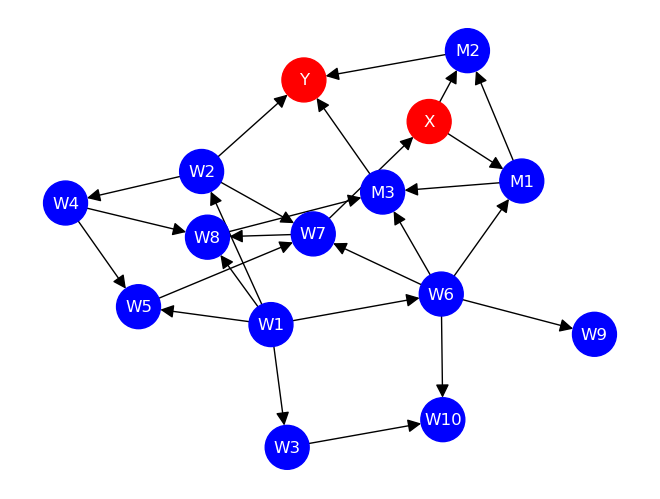

In [ ]:
draw_graph(graph_true, highlight_nodes={"X", "Y"})

In [ ]:
data = get_dataset(mixing_matrix=A, noise_vars=noise_vars,
                   num_samples=1000, labels=labels)
data.head()

,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,X,M1,M2,M3,Y
0,-0.524526,0.082740,0.511285,-0.428790,0.206569,-0.124775,-0.274969,0.975348,0.223864,-0.261680,-0.238098,0.389241,-0.567587,-0.837017,0.502616
1,0.292501,0.016717,0.320840,-0.879261,-0.427722,0.035111,-0.687620,0.801554,-0.022219,0.166778,0.362314,-0.447789,0.124390,-0.199582,-0.220629
2,-0.648133,0.562219,0.385289,-0.137838,0.348370,0.444976,-0.771743,0.694962,-0.790796,0.027081,0.493028,-0.227073,-0.071652,-0.614490,0.402219
3,0.344170,-0.317331,-0.397835,-0.059340,0.439778,-0.009194,-0.915783,0.124095,-0.216393,0.328786,0.710924,-0.776587,0.095804,0.129171,0.715350
4,0.534461,0.242387,-0.178900,-0.957031,-0.057134,-1.591982,2.103615,-2.068360,0.725326,0.228350,-1.610583,2.057864,0.274302,1.125149,-0.491953


In [ ]:
sample_cov = data.cov().values

In [ ]:
pc_alg = PCAlgorithm(use_ci_oracle=True, graph_true=graph_true)
cpdag_pc, _, _ = pc_alg.run(data)
print("Total CI tests done: %d" % pc_alg.ci_test_calls["total"])
print("Estimated ATE set: %s" % str(
    set(get_ATE_using_cov(g, sample_cov) for g in generate_local_dags_from(cpdag_pc))))

Total CI tests done: 4341
Estimated ATE set: {0.053902203097293586}


In [ ]:
mb_by_mb_alg = MBbyMBAlgorithm(use_ci_oracle=True, graph_true=graph_true)
result_mb_by_mb = mb_by_mb_alg.run(data)
print("Total CI tests done: %d" % mb_by_mb_alg.ci_test_calls["total"])
print("Estimated ATE set: %s" % str(
    set(get_ATE_using_nodes_and_cov(list(data.columns),
                                    list(result_mb_by_mb["tmt_parents"]) + par,
                                    sample_cov)
    for par in get_all_combinations(result_mb_by_mb["unoriented"], 
                                    result_mb_by_mb["non_colliders"]))))

Total CI tests done: 1466
Estimated ATE set: {0.053902203097293586}


In [ ]:
sd_alg = SequentialDiscoveryAlgorithm(use_ci_oracle=True, graph_true=graph_true)
result_sd = sd_alg.run(data)
print("Total CI tests done: %d" % sd_alg.ci_test_calls["total"])
print("Estimated ATE set: %s" % str(
    set(get_ATE_using_nodes_and_cov(list(data.columns),
                                    list(result_sd["tmt_parents"]) + par,
                                    sample_cov)
    for par in get_all_combinations(result_sd["unoriented"], 
                                    result_sd["non_colliders"]))))

Total CI tests done: 2711
Estimated ATE set: {0.053902203097293586}


In [ ]:
ldecc_alg = LDECCAlgorithm(use_ci_oracle=True, graph_true=graph_true, ldecc_do_checks=True)
result_ldecc = ldecc_alg.run(data)
print("Total CI tests done: %d" % ldecc_alg.ci_test_calls["total"])
print("Estimated ATE set: %s" % str(
    set(get_ATE_using_nodes_and_cov(list(data.columns),
                                    list(result_ldecc["tmt_parents"]) + par,
                                    sample_cov)
    for par in get_all_combinations(result_ldecc["unoriented"], 
                                    result_ldecc["non_colliders"]))))

Total CI tests done: 584
Estimated ATE set: {0.053902203097293586}


The code below evaluates the various algorithms on randomly generated linear graphs.
We use `ipyparallel` to execute the runs in parallel. The following command starts the `ipyparallel` engines:

```
ipcluster start -n <num_engines>
```

In [ ]:
import ipyparallel as ipp

In [ ]:
# Verify that ipcluster is running and import the necessary Python packages.

parallel_client = ipp.Client(debug=False)
dview = parallel_client[:]
# Execute an identity map in parallel.
ar = dview.map(lambda x: x, (i for i in range(0, 20000, 2)))
assert ar.get()[0] == 0

# Import the required Python packages.
with dview.sync_imports():
  import numpy
  import os
  import pandas
  import networkx
  from itertools import combinations, permutations
  import logging
  from causallearn.utils.cit import CIT
  import collections
  import copy
  import ipyparallel

  from causal_discovery.utils import orient_colliders, get_dataset, get_connected_component_with_node, remove_directed_only_edges, apply_meek_rules, adj_matrix_to_nx_graph, dag_to_cpdag, get_neighbor_types, get_all_combinations, get_ATE_using_nodes_and_cov, get_ATE_using_cov, generate_local_dags_from, to_dict    
  from causal_discovery.pc_alg import PCAlgorithm
  from causal_discovery.mb_by_mb import MBbyMBAlgorithm
  from causal_discovery.sd_alg import SequentialDiscoveryAlgorithm
  from causal_discovery.ldecc import LDECCAlgorithm
  
  try:
    from cPickle import dumps, loads, HIGHEST_PROTOCOL as PICKLE_PROTOCOL
  except ImportError:
    from pickle import dumps, loads, HIGHEST_PROTOCOL as PICKLE_PROTOCOL

# Make sure ipyparallel is still able to execute functions.
dview = parallel_client[:]
ar = dview.map(lambda x: x, (i for i in range(0, 20000, 2)))
assert ar.get()[0] == 0

In [ ]:
def execute_iteration(params, num_samples, seed, run_oracle=False, 
                      progress_log_filepath=None):
  np = numpy
  nx = networkx
  
  np.random.seed(seed)

  # linearly scale down alpha.
  alpha = (32000 / num_samples) * 0.01

  result = {
      "graph_true_sample_cov_ate": None,
      "oracle": {
          "ate": None,
          "neighbors": None,
      },
      "oracle_sample_cov": {
          "ate": None,
      },
      "pc-alg": {
          "ci_tests": None,
          "ate": None,
          "neighbors": None,
      },
      "ldecc": {
          "ci_tests": None,
          "ate": None,
          "neighbors": None,
      },
      "ldecc-checks": {
          "ci_tests": None,
          "ate": None,
          "neighbors": None,
      },
      "mb-by-mb": {
          "ci_tests": None,
          "ate": None,
          "neighbors": None,
      },
      "sd-alg": {
          "ci_tests": None,
          "ate": None,
          "neighbors": None,
      },
      # oracle CI results.
      "pc-alg-oracle": {
          "ci_tests": None,
      },
      "ldecc-oracle": {
          "ci_tests": None,
      },
      "sd-alg-oracle": {
          "ci_tests": None,
      },
      "mb-by-mb-oracle": {
          "ci_tests": None,
      },
  }

  A, noise_vars, labels, cov_matrix = params
  graph_true = adj_matrix_to_nx_graph(A, labels)
  data = get_dataset(mixing_matrix=A, noise_vars=noise_vars,
                     num_samples=num_samples, labels=labels)
  sample_cov = data.cov().values

  result["graph_true_sample_cov_ate"] = get_ATE_using_cov(graph_true, sample_cov)

  cpdag_oracle = dag_to_cpdag(graph_true)
  result["oracle"]["ate"] = [get_ATE_using_cov(g, cov_matrix) 
                             for g in generate_local_dags_from(cpdag_oracle)]
  result["oracle"]["neighbors"] = get_neighbor_types(cpdag_oracle, "X")                           
  
  result["oracle_sample_cov"]["ate"] = [get_ATE_using_cov(g, sample_cov)
                                        for g in generate_local_dags_from(cpdag_oracle)]

  pc_alg = PCAlgorithm(use_ci_oracle=False, alpha=alpha)
  cpdag_pc, _, _ = pc_alg.run(data)
  result["pc-alg"]["ci_tests"] = to_dict(pc_alg.ci_test_calls)
  result["pc-alg"]["neighbors"] = get_neighbor_types(cpdag_pc, "X")
  result["pc-alg"]["ate"] = [get_ATE_using_cov(g, sample_cov)
                             for g in generate_local_dags_from(cpdag_pc)]
  
  ldecc_alg = LDECCAlgorithm(use_ci_oracle=False, alpha=alpha, ldecc_do_checks=False)
  result_ldecc = ldecc_alg.run(data)
  result["ldecc"]["ci_tests"] = to_dict(ldecc_alg.ci_test_calls)
  result["ldecc"]["neighbors"] = {
      "parents": result_ldecc["tmt_parents"],
      "children": result_ldecc["tmt_children"],
      "unoriented": result_ldecc["unoriented"], 
  }
  tmt_par = list(result_ldecc["tmt_parents"])
  ate_ldecc = [get_ATE_using_nodes_and_cov(list(data.columns), tmt_par + par, sample_cov)
               for par in get_all_combinations(result_ldecc["unoriented"], result_ldecc["non_colliders"])]
  result["ldecc"]["ate"] = ate_ldecc

  ldecc_alg = LDECCAlgorithm(use_ci_oracle=False, alpha=alpha, ldecc_do_checks=True)
  result_ldecc = ldecc_alg.run(data)
  result["ldecc-checks"]["ci_tests"] = to_dict(ldecc_alg.ci_test_calls)
  result["ldecc-checks"]["neighbors"] = {
      "parents": result_ldecc["tmt_parents"],
      "children": result_ldecc["tmt_children"],
      "unoriented": result_ldecc["unoriented"], 
  }
  tmt_par = list(result_ldecc["tmt_parents"])
  ate_ldecc = [get_ATE_using_nodes_and_cov(list(data.columns), tmt_par + par, sample_cov)
               for par in get_all_combinations(result_ldecc["unoriented"], result_ldecc["non_colliders"])]
  result["ldecc-checks"]["ate"] = ate_ldecc

  mb_by_mb_alg = MBbyMBAlgorithm(use_ci_oracle=False, alpha=alpha)
  result_mb = mb_by_mb_alg.run(data)
  result["mb-by-mb"]["ci_tests"] = to_dict(mb_by_mb_alg.ci_test_calls)
  result["mb-by-mb"]["neighbors"] = {
      "parents": result_mb["tmt_parents"],
      "children": result_mb["tmt_children"],
      "unoriented": result_mb["unoriented"], 
  }
  tmt_par = list(result_mb["tmt_parents"])
  ate_mb = [get_ATE_using_nodes_and_cov(list(data.columns), tmt_par + par, sample_cov)
            for par in get_all_combinations(result_mb["unoriented"], result_mb["non_colliders"])]
  result["mb-by-mb"]["ate"] = ate_mb

  sd_alg = SequentialDiscoveryAlgorithm(use_ci_oracle=False, alpha=alpha)
  result_sd = sd_alg.run(data)
  result["sd-alg"]["ci_tests"] = to_dict(sd_alg.ci_test_calls)
  result["sd-alg"]["neighbors"] = {
      "parents": result_sd["tmt_parents"],
      "children": result_sd["tmt_children"],
      "unoriented": result_sd["unoriented"], 
  }
  tmt_par = list(result_sd["tmt_parents"])
  ate_sd = [get_ATE_using_nodes_and_cov(list(data.columns), tmt_par + par, sample_cov)
            for par in get_all_combinations(result_sd["unoriented"], result_sd["non_colliders"])]
  result["sd-alg"]["ate"] = ate_sd

  # Results when a CI oracle is used.
  if run_oracle:
    pc_alg = PCAlgorithm(use_ci_oracle=True, graph_true=graph_true)
    cpdag_pc, _, _ = pc_alg.run(data)
    result["pc-alg-oracle"]["ci_tests"] = to_dict(pc_alg.ci_test_calls)
    
    ldecc_alg = LDECCAlgorithm(use_ci_oracle=True, graph_true=graph_true)
    result_ldecc = ldecc_alg.run(data)
    result["ldecc-oracle"]["ci_tests"] = to_dict(ldecc_alg.ci_test_calls)
    
    sd_alg = SequentialDiscoveryAlgorithm(use_ci_oracle=True, graph_true=graph_true)
    result_sd = sd_alg.run(data)
    result["sd-alg-oracle"]["ci_tests"] = to_dict(sd_alg.ci_test_calls)

    mb_by_mb_alg = MBbyMBAlgorithm(use_ci_oracle=True, graph_true=graph_true)
    result_mb = mb_by_mb_alg.run(data)
    result["mb-by-mb-oracle"]["ci_tests"] = to_dict(mb_by_mb_alg.ci_test_calls)

  if progress_log_filepath is not None:
    os.system("echo '%d' >> %s" % (seed, progress_log_filepath))

  np.random.seed(None)
  return result

In [ ]:
def async_results_to_results(async_results, results):
  for N, ar in zip(results["sample_sizes"], async_results):
    if N not in results:
      results[N] = []
    for r in ar.get():
      results[N].append(r)
  return results

def execute_estimation_in_parallel(results, start_graph, end_graph, iters_per_graph=1):

  num_threads = len(parallel_client.ids)
  dview = parallel_client[:]

  num_graphs = end_graph - start_graph
  print("Executing %d iterations across %d engines" % (
      num_graphs*iters_per_graph, num_threads))

  dview["get_dataset"] = get_dataset
  dview["get_noise_matrix"] = get_noise_matrix
  dview["execute_iteration"] = execute_iteration

  # The random seed below replicates the results in the paper.
  RANDOM_SEED = 716697
  np.random.seed(RANDOM_SEED)
  new_param_list = []
  for _ in range(start_graph, end_graph):
    NUM_COVARIATES = 20
    NUM_MEDIATORS = 3
    A, noise_vars, labels, cov_matrix = get_params(num_conf=NUM_COVARIATES,
                                                    num_med=NUM_MEDIATORS,
                                                    p_link_conf=0.10,
                                                    p_link_conf_med=0.05,
                                                    p_link_med=0.1,
                                                    p_link_x=0.1,
                                                    p_link_y=0.1)
    params = (A, noise_vars, labels, cov_matrix)
    graph_true = adj_matrix_to_nx_graph(A, labels)

    for graph_iter in range(iters_per_graph):
      new_param_list.append(params)
      results["params"].append(params)
      results["ground_truth_ate"].append(get_ATE_using_cov(graph_true, cov_matrix))
      
  sample_sizes = [8000, 16000, 24000, 32000]
  results["sample_sizes"] = sample_sizes
  async_results = []
  for N in sample_sizes:
    print("%s: Starting iterations %d for N=%d" % (
        str(datetime.now()), len(new_param_list), N))
    
    def execute_estimation_iteration(i):
      return execute_iteration(new_param_list[i], N, (RANDOM_SEED + N + i),
                               run_oracle=(N==sample_sizes[0]))
    
    async_result = dview.map(execute_estimation_iteration, range(len(new_param_list)))
    async_results.append(async_result)

  np.random.seed(None)
  return results, async_results

In [ ]:
results = {}
results.update({
    "params": [],
    "ground_truth_ate": [],
})

results, async_results = execute_estimation_in_parallel(results, 
                                                        start_graph=0,
                                                        end_graph=250,
                                                        iters_per_graph=5)

In [ ]:
# Monitor progress of the tasks.
for ar in async_results:
  ar.wait_interactive(timeout=1)

In [ ]:
results = async_results_to_results(async_results, results)

The code below plots the results.

In [ ]:
# For the color map:
# https://gist.github.com/AndiH/c957b4d769e628f506bd

# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
             
# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE+6)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE+6)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE + 4)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE+4)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE+2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE+20)  # fontsize of the figure title

In [ ]:
plot_prop = {
    "pc-alg": ["dashed", tableau20blind[0], "o"],
    "ldecc": ["dashdot", tableau20blind[1], "^"],
    "ldecc-checks": ["solid", tableau20blind[5], "s"],
    "mb-by-mb": ["dashdot", tableau20blind[7], "D"],
    "sd-alg": ["dotted", tableau20blind[3], "v"],
}

In [ ]:
def get_hausdorff_distance(arr_1, arr_2):

  arr_1 = np.array(arr_1)
  arr_2 = np.array(arr_2)

  def get_distance_point_from_array(point, arr):
    return np.min(np.abs(arr - point))

  dist_1_to_2 = np.max([get_distance_point_from_array(p, arr_2) for p in arr_1])
  dist_2_to_1 = np.max([get_distance_point_from_array(p, arr_1) for p in arr_2])

  return max(dist_1_to_2, dist_2_to_1)

def plot_mse(results):
  plt.figure(figsize=(6, 4))
  samples = results["sample_sizes"]

  dict_to_name = {
      'pc-alg': "PC", 
      'ldecc': "LDECC", 
      'ldecc-checks': "LDECC-checks",
      'sd-alg': "SD",
      'mb-by-mb': "MB-by-MB",
  }

  errors = collections.defaultdict(list)

  for N in samples:
    for k in dict_to_name.keys():
      errors[k].append([])

    for i, res in enumerate(results[N]):
      for k in dict_to_name.keys():
        errors[k][-1].append(get_hausdorff_distance(
            res["oracle"]["ate"], res[k]["ate"]
        )**2)

      
  samples = np.array(samples)
  mses = {}
  stds = {}
  for k in dict_to_name.keys():
    errors[k] = np.array(errors[k])
    mses[k] = np.mean(errors[k], axis=-1)
    stds[k] = np.std(errors[k], axis=-1)

    plt.plot(samples, mses[k], label=dict_to_name[k],
             color=plot_prop[k][1], linestyle=plot_prop[k][0],
             marker=plot_prop[k][2])
    ci = 1.96 * stds[k] / np.sqrt(errors[k].shape[-1])
    plt.errorbar(samples, mses[k],
                 yerr=ci, ls="none", color=plot_prop[k][1])
  
  plt.title("MSE vs Sample size")
  plt.xlabel("Sample size")
  plt.ylabel("MSE (Hausdorff distance)")
  plt.ylim(bottom=-0.05)
  plt.legend()
  plt.show()
  
plot_mse(results)

In [ ]:
def plot_accuracy(results):

  dict_to_name = {
      'pc-alg': "PC", 
      'ldecc': "LDECC", 
      'ldecc-checks': "LDECC-checks",
      'sd-alg': "SD",
      'mb-by-mb': "MB-by-MB",
  }

  def get_detected_neighbors(r):
    return r["neighbors"]["parents"], r["neighbors"]["children"], r["neighbors"]["unoriented"]
  
  def is_correct_adj_set(pa, ch, uo, pa_or, ch_or, uo_or):

    if uo == set() and uo == uo_or:
      return pa == pa_or
    
    return pa == pa_or and ch == ch_or and uo == uo_or

  N = len(results[results["sample_sizes"][0]])
  print("Total = %d" % N)

  same_count = collections.defaultdict(lambda: 0)
  correct_count = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
  
  for s in results["sample_sizes"]:
    for i in range(N):
      parents_or, children_or, uo_or = get_detected_neighbors(results[s][i]["oracle"])
      
      for k in dict_to_name.keys():
        parents, children, uo = get_detected_neighbors(results[s][i][k]) 
        if is_correct_adj_set(parents, children, uo, parents_or, children_or, uo_or):
          correct_count[k][s] += 1
        
  plt.figure(figsize=(6, 4))

  accuracy = {}
  samples = results["sample_sizes"]
  for k in dict_to_name.keys():
    accuracy[k] = np.array([correct_count[k][s] * 100 / N for s in samples])

    plt.plot(samples, accuracy[k], label=dict_to_name[k],
             color=plot_prop[k][1], linestyle=plot_prop[k][0],
             marker=plot_prop[k][2])
  
  plt.title("Accuracy vs Sample size")
  plt.xlabel("Sample size")
  plt.ylabel("Accuracy (%)")
  plt.legend()
  plt.show()

plot_accuracy(results)

In [ ]:
def plot_recall(results):

  dict_to_name = {
      'pc-alg': "PC", 
      'ldecc': "LDECC", 
      'ldecc-checks': "LDECC-checks",
      'sd-alg': "SD",
      'mb-by-mb': "MB-by-MB",
  }

  N = len(results[results["sample_sizes"][0]])
  
  correct_count = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
  
  for s in results["sample_sizes"]:
    for i in range(N):
      for k in dict_to_name.keys():
        
        if results[s][i]["graph_true_sample_cov_ate"] in results[s][i][k]["ate"]:
          correct_count[k][s] += 1
  
  plt.figure(figsize=(6, 4))
  
  coverage = {}
  samples = results["sample_sizes"]
  for k in dict_to_name.keys():
    coverage[k] = np.array([correct_count[k][s] * 100 / N for s in samples])

    plt.plot(samples, coverage[k], label=dict_to_name[k],
             color=plot_prop[k][1], linestyle=plot_prop[k][0],
             marker=plot_prop[k][2])
  
  plt.title("Recall vs Sample size")
  plt.xlabel("Sample size")
  plt.ylabel("Recall (%)")
  plt.ylim(bottom=10)
  plt.legend()
  plt.show()

plot_recall(results)

In [ ]:
def plot_number_of_tests(results):

  plt.figure(figsize=(6, 4))

  dict_to_name = {
      'pc-alg': "PC", 
      'ldecc': "LDECC", 
      'ldecc-checks': "LDECC-checks",
      'sd-alg': "SD",
      'mb-by-mb': "MB-by-MB",
  }

  samples = results["sample_sizes"]
  samples = np.array(samples)
  
  tests_count = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
  for k in dict_to_name.keys():
    for s in samples:
      tests_count[k][s] = np.mean([t[k]["ci_tests"]["total"] for t in results[s]])

  for k in dict_to_name.keys():
    plt.plot(samples, [tests_count[k][s] for s in samples], label=dict_to_name[k],
             color=plot_prop[k][1], linestyle=plot_prop[k][0],
             marker=plot_prop[k][2])

  
  plt.title("Number of CI tests")
  plt.xlabel("Sample size")
  plt.ylabel("Number of CI tests")
  plt.ylim(bottom=0)
  plt.legend(loc=(0.67, 0.555))
  plt.show()

plot_number_of_tests(results)

In [ ]:
def plot_test_statistics(results, range_start=0, range_end=30000):
  plt.figure(figsize=(6, 4))

  res = [r for i, r in enumerate(results[8000]) if i%5==0]
  total_tests_pc = [r["pc-alg-oracle"]["ci_tests"]["total"]
                        for r in res]
  total_tests_ldecc = [r["ldecc-oracle"]["ci_tests"]["total"]
                        for r in res]
  total_tests_sd = [r["sd-alg-oracle"]["ci_tests"]["total"]
                        for r in res]
  total_tests_mb = [r["mb-by-mb-oracle"]["ci_tests"]["total"]
                        for r in res]
  
  plt.hist([total_tests_pc, total_tests_ldecc, total_tests_sd, total_tests_mb],
           label=["PC", "LDECC", "SD", "MB-by-MB"],
           range=[0, 20000],
           color=[plot_prop["pc-alg"][1], plot_prop["ldecc"][1], 
                  plot_prop["sd-alg"][1], plot_prop["mb-by-mb"][1]])
  plt.legend()
  plt.title("Distribution of CI tests")
  plt.xlabel("Number of tests")
  plt.ylabel("Number of graphs")
  plt.show()

plot_test_statistics(results)